In [115]:
# Import libraries
import os
from pathlib import Path
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GroupKFold , GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


import warnings

warnings.filterwarnings('ignore')

# Set Pandas with to maximu view
pd.set_option('display.max_columns', None)

In [116]:
# set data dir
DATA_DIR = Path('data/')
os.listdir(DATA_DIR)

['SampleSubmission.csv', 'Test.csv', 'Train.csv']

In [117]:
# Load files and clean dataset
train = os.path.join(DATA_DIR / 'Train.csv')

# create functions for Data Cleaning
def load_and_clean_dataset(data_path:str) -> pd.DataFrame:
    """Load and clean dataset to meet model standard"""

    # load datasets
    df = pd.read_csv(data_path)
    
    # drop duplicates
    df = df.drop_duplicates()

    # convert data to datatime
    df['time'] = pd.to_datetime(df['time'])

    # Set the index time 
    df.index = df['time']
     
    return df


df = load_and_clean_dataset(train)
df.head()

,ID,time,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target
time,,,,,,,,,,,,,,,,,,,,
2021-01-04,1D_0000,2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2021-01-09,1D_0000,2021-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2021-01-14,1D_0000,2021-01-14,0.0845,0.1030,0.0583,0.1977,0.1152,0.0464,0.0742,0.1326,0.1682,0.2243,0.2500,0.0347,0.0007,0.544531,0.263663,-0.401134,0.120000,0.0
2021-01-19,1D_0000,2021-01-19,0.1095,0.1357,0.0858,0.1596,0.0782,0.0330,0.0873,0.1620,0.1396,0.1736,0.1820,0.0260,0.0011,0.300733,0.342304,-0.186176,0.008666,0.0
2021-01-24,1D_0000,2021-01-24,0.1128,0.1300,0.0919,0.2141,0.1240,0.0608,0.1035,0.1546,0.1845,0.2302,0.2606,0.0703,0.0041,0.399346,0.266489,-0.309881,0.059365,0.0


In [118]:
# check shape of the dataset
df.shape

(7556974, 20)

In [119]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7556974 entries, 2021-01-04 to 2023-04-06
Data columns (total 20 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ID           object        
 1   time         datetime64[ns]
 2   Green        float64       
 3   Blue         float64       
 4   RED          float64       
 5   NIR          float64       
 6   SWIR1        float64       
 7   SWIR2        float64       
 8   Red_Edge     float64       
 9   Aerosols     float64       
 10  Red_Edge_2   float64       
 11  Red_Edge_3   float64       
 12  Red_Edge_4   float64       
 13  Water_vapor  float64       
 14  Cirrus       float64       
 15  NDVI         float64       
 16  NDMI         float64       
 17  NDWI         float64       
 18  CI           float64       
 19  Target       float64       
dtypes: datetime64[ns](1), float64(18), object(1)
memory usage: 1.2+ GB


In [120]:
# describe dataset
df.describe()

,time,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target
count,7556974,5.209641e+06,5.209170e+06,5.209987e+06,5.209511e+06,5.209150e+06,5.210218e+06,5.210114e+06,5.212199e+06,5.210359e+06,5.210867e+06,5.211325e+06,5.212533e+06,5.208790e+06,5.209133e+06,5.208357e+06,5.209412e+06,5.209654e+06,7.556973e+06
mean,2022-11-27 11:19:01.575980544,2.684166e-01,2.850377e-01,2.610897e-01,3.875546e-01,2.682356e-01,1.695229e-01,2.705342e-01,3.070171e-01,3.607554e-01,4.173168e-01,4.461047e-01,9.932354e-02,1.949226e-02,3.033566e-01,1.888009e-01,-2.538741e-01,6.334171e-02,8.699735e-01
min,2021-01-01 00:00:00,4.780000e-02,6.920000e-02,2.740000e-02,5.600000e-02,0.000000e+00,7.000000e-03,2.910000e-02,9.220000e-02,5.590000e-02,6.560000e-02,6.560000e-02,5.700000e-03,3.000000e-04,-5.265151e-01,-5.882127e-01,-7.119470e-01,-3.848435e-01,0.000000e+00
25%,2021-12-12 00:00:00,1.110000e-01,1.245000e-01,8.410000e-02,2.632000e-01,1.762000e-01,8.120000e-02,1.099000e-01,1.548000e-01,2.252000e-01,2.817000e-01,3.129000e-01,4.100000e-02,1.300000e-03,8.437500e-02,1.048610e-01,-3.970937e-01,-2.977590e-03,0.000000e+00
50%,2022-11-27 00:00:00,1.670000e-01,1.823000e-01,1.515000e-01,3.361000e-01,2.228000e-01,1.337000e-01,1.669000e-01,2.108000e-01,2.903000e-01,3.621000e-01,3.981000e-01,5.850000e-02,2.400000e-03,2.861142e-01,1.859019e-01,-2.349304e-01,3.739575e-02,1.000000e+00
75%,2023-11-15 00:00:00,3.865000e-01,4.035000e-01,3.967000e-01,4.763000e-01,3.505000e-01,2.475000e-01,3.927000e-01,4.155000e-01,4.606000e-01,5.161000e-01,5.435000e-01,1.120000e-01,9.900000e-03,5.009573e-01,2.633517e-01,-9.824108e-02,1.141907e-01,2.000000e+00
max,2024-10-30 00:00:00,1.296700e+00,1.319500e+00,1.406600e+00,1.352100e+00,8.688000e-01,1.214100e+00,1.344900e+00,1.288500e+00,1.374800e+00,1.479800e+00,1.501400e+00,1.129100e+00,5.925000e-01,8.473346e-01,8.933561e-01,3.919564e-01,5.467024e-01,2.000000e+00
std,NaN,2.075962e-01,2.120764e-01,2.297003e-01,1.746180e-01,1.305282e-01,1.067340e-01,2.140201e-01,2.033700e-01,1.875899e-01,1.865351e-01,1.847108e-01,1.102550e-01,5.538891e-02,2.296730e-01,1.298786e-01,1.718510e-01,8.349652e-02,8.833301e-01


In [121]:
# total datasets
len(df)

7556974

In [122]:
df['ID'].nunique()

26184

In [123]:
def extract_time(df: pd.DataFrame) -> pd.DataFrame:
    """Create time-based features from the DataFrame index.
    Crops and other features change with time, so we extract
    month and day features to help capture seasonal patterns.
    """
    # Create date features from index
    df['day']= df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year

    df['month_year'] = df['month'].astype(str) + '_' + df['year'].astype(str)
    
    return df

df = extract_time(df)

In [124]:
# check if the ID and the Target are both unique together
is_unique = len(df['ID'].unique()) == len(df.groupby(['ID', 'Target']))
print(is_unique)

False


IF they are both unique it means the target is not changing, the target is the same overtime

In [125]:
# def fill_missing_value(df):
#     # Convert Pandas DataFrame to Polars
#     pl_df = pl.from_pandas(df)

#     # List of columns to fill
#     cols_to_fill = ['Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2',
#                     'Red_Edge', 'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4',
#                     'Water_vapor', 'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'day',
#                     'month', 'year', 'Target']

#     # Step 1: Fill missing values with the median based on ("ID", "month_year")
#     filled_df = pl_df.with_columns([
#         pl.col(c).fill_null(pl.col(c).mean().over(["ID", "month_year"])) for c in cols_to_fill
#     ])

#     # Step 2: Fill remaining null values with the yearly mean for each "ID"
#     filled_df = filled_df.with_columns([
#         pl.col(c).fill_null(pl.col(c).mean().over(["ID", "year"])) for c in cols_to_fill
#     ])

#     # Step 3: Forward fill (ffill) missing values within each "ID"
#     filled_df = filled_df.with_columns([
#         pl.col(c).fill_null(strategy="forward").over("ID") for c in cols_to_fill
#     ])

#     # Step 3: Forward fill (ffill) missing values within each "ID"
#     filled_df = filled_df.with_columns([
#         pl.col(c).fill_null(strategy="backward").over("ID") for c in cols_to_fill
#     ])

#     # Convert back to Pandas if needed
#     df = filled_df.to_pandas()
    
#     return df

In [126]:
def fill_missing_value(df):
    # Convert Pandas DataFrame to Polars
    pl_df = pl.from_pandas(df)

    # List of columns to fill
    cols_to_fill = ['Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2',
                    'Red_Edge', 'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4',
                    'Water_vapor', 'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'CI', 'day',
                    'month', 'year', 'Target']

    # Step 1: Fill missing values with the median based on ("ID", "month_year")
    filled_df = pl_df.with_columns([
        pl.col(c).fill_null(pl.col(c).mean().over(["ID"])) for c in cols_to_fill
    ])

    # Convert back to Pandas if needed
    df = filled_df.to_pandas()
    
    return df

df = fill_missing_value(df)
df.head()

,ID,time,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target,day,month,year,month_year
0,1D_0000,2021-01-04,0.265979,0.286144,0.25969,0.367115,0.243527,0.15161,0.2632,0.307138,0.340618,0.399149,0.426868,0.08754,0.009998,0.302709,0.231466,-0.243403,0.051841,0.0,4.0,1.0,2021.0,1_2021
1,1D_0000,2021-01-09,0.265979,0.286144,0.25969,0.367115,0.243527,0.15161,0.2632,0.307138,0.340618,0.399149,0.426868,0.08754,0.009998,0.302709,0.231466,-0.243403,0.051841,0.0,9.0,1.0,2021.0,1_2021
2,1D_0000,2021-01-14,0.084500,0.103000,0.05830,0.197700,0.115200,0.04640,0.0742,0.132600,0.168200,0.224300,0.250000,0.03470,0.000700,0.544531,0.263663,-0.401134,0.120000,0.0,14.0,1.0,2021.0,1_2021
3,1D_0000,2021-01-19,0.109500,0.135700,0.08580,0.159600,0.078200,0.03300,0.0873,0.162000,0.139600,0.173600,0.182000,0.02600,0.001100,0.300733,0.342304,-0.186176,0.008666,0.0,19.0,1.0,2021.0,1_2021
4,1D_0000,2021-01-24,0.112800,0.130000,0.09190,0.214100,0.124000,0.06080,0.1035,0.154600,0.184500,0.230200,0.260600,0.07030,0.004100,0.399346,0.266489,-0.309881,0.059365,0.0,24.0,1.0,2021.0,1_2021


In [127]:
# checking if there is any missing value
df.isna().sum()

ID             0
time           0
Green          0
Blue           0
RED            0
NIR            0
SWIR1          0
SWIR2          0
Red_Edge       0
Aerosols       0
Red_Edge_2     0
Red_Edge_3     0
Red_Edge_4     0
Water_vapor    0
Cirrus         0
NDVI           0
NDMI           0
NDWI           0
CI             0
Target         0
day            0
month          0
year           0
month_year     0
dtype: int64

## Explore Datasets

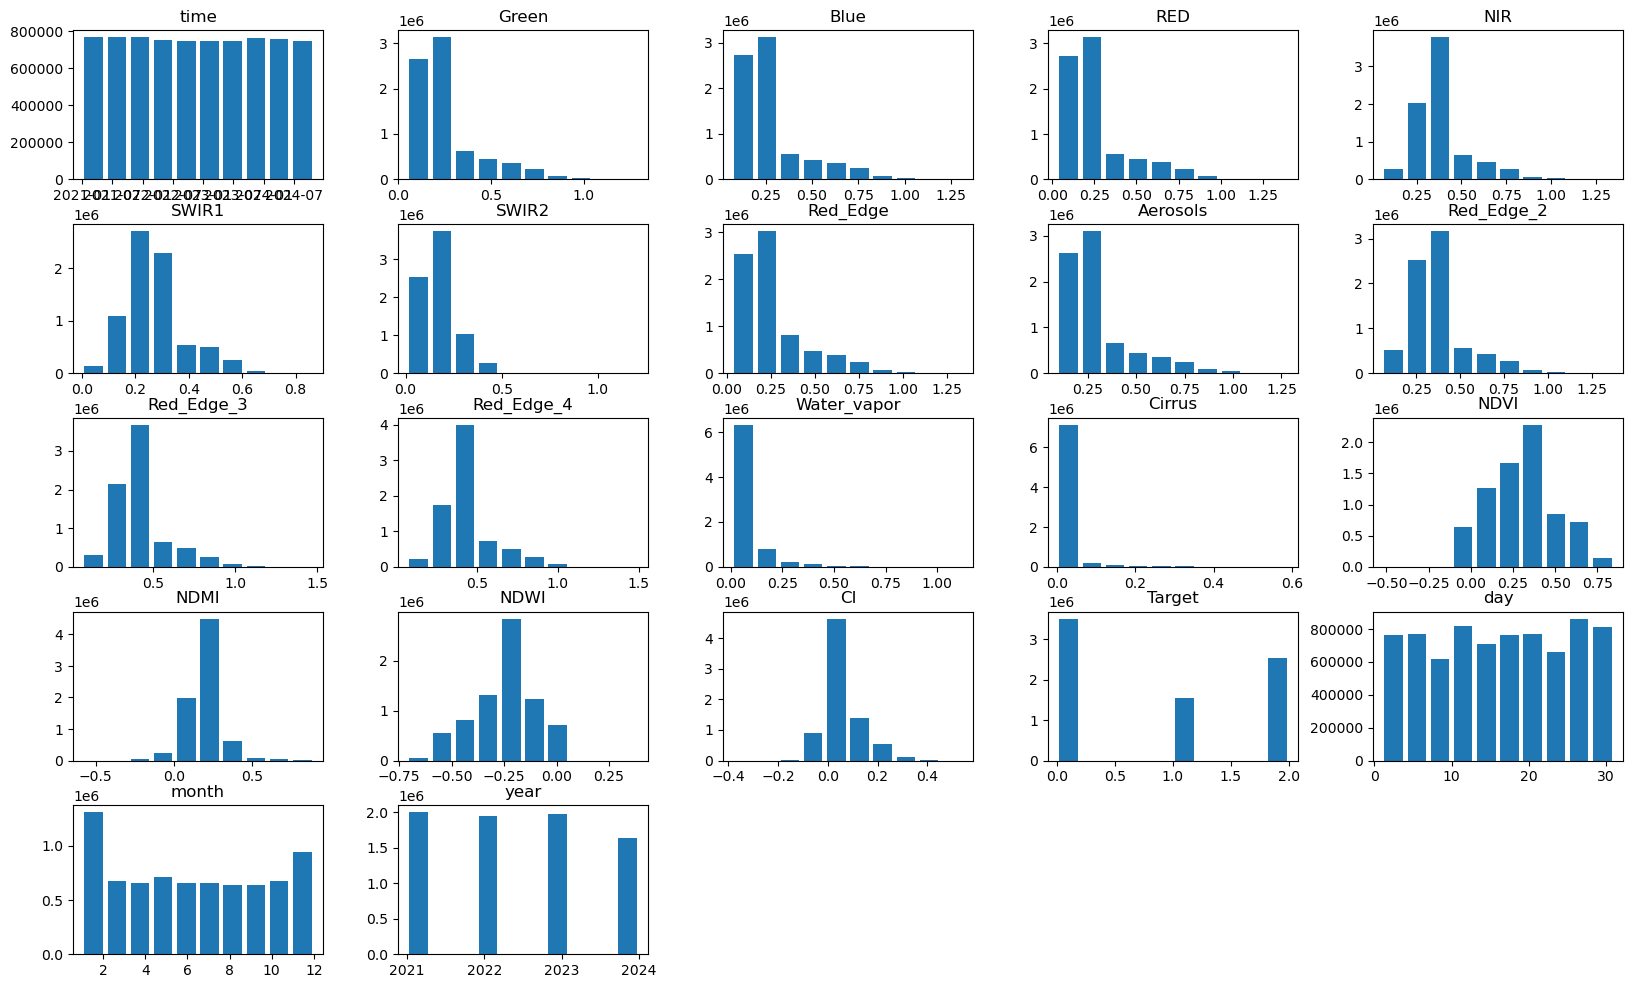

In [128]:
# plot an histogram chart of each data points
cols = df.columns
df[cols].hist(grid=False, figsize=(20, 12), rwidth=0.8) 
plt.show()

check the Distbution of the Taget datasets

<AxesSubplot: xlabel='Target'>

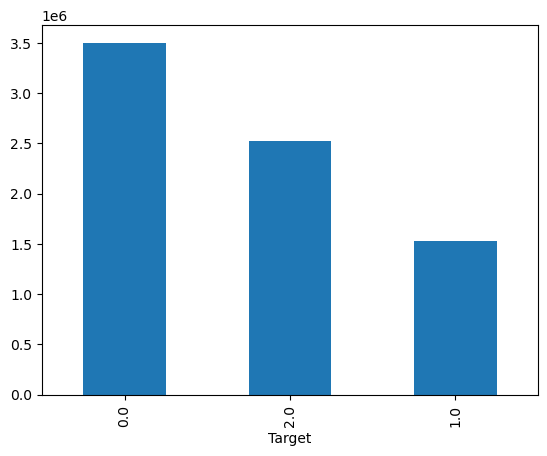

In [129]:
df['Target'].value_counts().plot(kind='bar')

Correlation heat map 

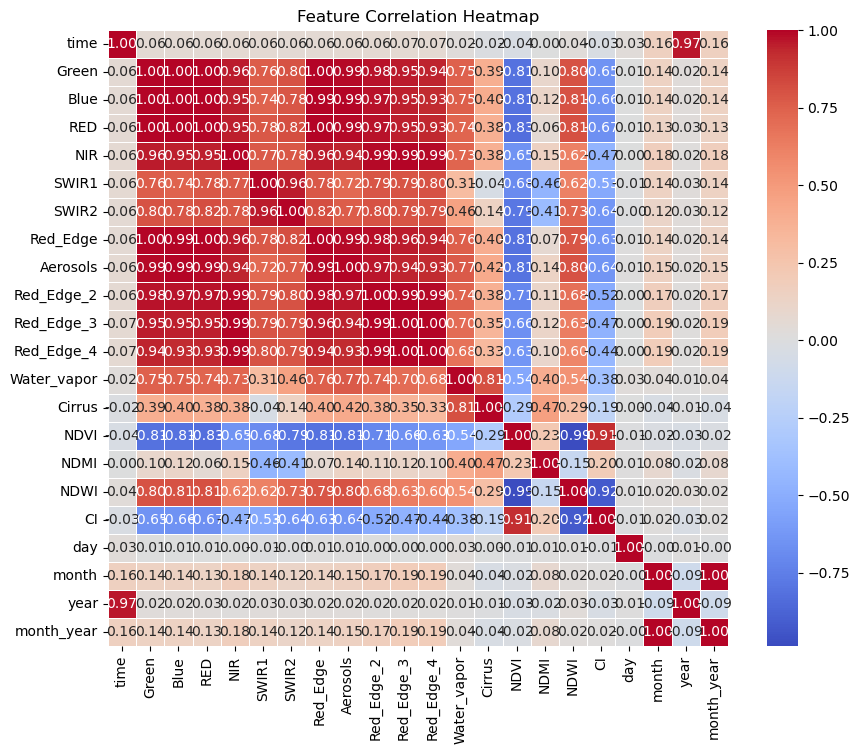

In [130]:
# Compute correlation matrix (excluding 'Target')
df_corr = df.drop(['Target','ID'], axis=1).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

## Feature Engineering 

In [131]:
# Sentinel Hub EVI script: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/evi/
def feature_eng_evi(df, nir_col='NIR', red_col='RED', blue_col='Blue', evi_col='EVI'):
    """
    Enhanced Vegetation Index (EVI) improves NDVI by:
    - Incorporating blue band reflectance for atmospheric correction
    - Reducing saturation in high biomass areas
    - Increasing sensitivity to canopy structure and vegetation density
    
    Formula:
    EVI = 2.5 * (NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1)
    """
    # Validate input columns exist
    required_cols = [nir_col, red_col, blue_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Calculate EVI 
    numerator = df[nir_col] - df[red_col]
    denominator = df[nir_col] + 6 * df[red_col] - 7.5 * df[blue_col] + 1
    
    df[evi_col] = 2.5 * numerator / denominator
    
    # Clip values to range (-1, 1)
    df[evi_col] = df[evi_col].clip(-1, 1)
    
    return df

df = feature_eng_evi(df)
df.head()


,ID,time,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,CI,Target,day,month,year,month_year,EVI
0,1D_0000,2021-01-04,0.265979,0.286144,0.25969,0.367115,0.243527,0.15161,0.2632,0.307138,0.340618,0.399149,0.426868,0.08754,0.009998,0.302709,0.231466,-0.243403,0.051841,0.0,4.0,1.0,2021.0,1_2021,0.344678
1,1D_0000,2021-01-09,0.265979,0.286144,0.25969,0.367115,0.243527,0.15161,0.2632,0.307138,0.340618,0.399149,0.426868,0.08754,0.009998,0.302709,0.231466,-0.243403,0.051841,0.0,9.0,1.0,2021.0,1_2021,0.344678
2,1D_0000,2021-01-14,0.084500,0.103000,0.05830,0.197700,0.115200,0.04640,0.0742,0.132600,0.168200,0.224300,0.250000,0.03470,0.000700,0.544531,0.263663,-0.401134,0.120000,0.0,14.0,1.0,2021.0,1_2021,0.449677
3,1D_0000,2021-01-19,0.109500,0.135700,0.08580,0.159600,0.078200,0.03300,0.0873,0.162000,0.139600,0.173600,0.182000,0.02600,0.001100,0.300733,0.342304,-0.186176,0.008666,0.0,19.0,1.0,2021.0,1_2021,0.280972
4,1D_0000,2021-01-24,0.112800,0.130000,0.09190,0.214100,0.124000,0.06080,0.1035,0.154600,0.184500,0.230200,0.260600,0.07030,0.004100,0.399346,0.266489,-0.309881,0.059365,0.0,24.0,1.0,2021.0,1_2021,0.386464


In [132]:
def aggregate_dataset(df):
    cols_to_fill = ['Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2',
                'Red_Edge', 'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4',
                'Water_vapor', 'Cirrus', 'NDVI', 'NDMI', 'NDWI','EVI', 'CI', 'Target']

    df_filled = df.groupby("ID")[cols_to_fill].mean().reset_index()
    return df_filled

df = aggregate_dataset(df)

In [133]:
len(df)

26184

In [134]:
df.columns

Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
       'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
       'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'EVI', 'CI', 'Target'],
      dtype='object')

In [135]:
# test if there is no duplicates 'ID'
assert df.groupby("ID")["Target"].nunique().max() == 1
assert df.groupby("ID")["Target"].nunique().min() == 1

In [136]:
# Add high-cardinality / redundant column
df_cleaned = df.drop(['ID'],axis =1)
df_cleaned.head()

,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,EVI,CI,Target
0,0.265979,0.286144,0.259690,0.367115,0.243527,0.151610,0.263200,0.307138,0.340618,0.399149,0.426868,0.087540,0.009998,0.302709,0.231466,-0.243403,0.346098,0.051841,0.0
1,0.270399,0.289763,0.264174,0.379766,0.251989,0.156691,0.267897,0.309484,0.348151,0.408359,0.437205,0.087958,0.010103,0.301717,0.229815,-0.248447,0.365610,0.048843,0.0
2,0.266084,0.286621,0.260865,0.366290,0.244240,0.153181,0.264412,0.307138,0.340472,0.398143,0.426066,0.087540,0.009998,0.299347,0.229222,-0.242578,0.338573,0.049452,0.0
3,0.266266,0.286324,0.261431,0.361451,0.244240,0.153181,0.264412,0.307138,0.340472,0.398143,0.426066,0.087540,0.009998,0.289909,0.219154,-0.233115,0.323528,0.048114,0.0
4,0.267871,0.287685,0.262368,0.365190,0.245247,0.154097,0.265682,0.307881,0.342562,0.400874,0.427879,0.088396,0.009946,0.292328,0.221873,-0.233907,0.332660,0.050417,0.0


## Split data into train and validation test

In [ ]:
# split data into train and validation test
feature = 'Target'
X = df_cleaned.drop(feature, axis=1)
y = df_cleaned[feature]

In [138]:
# create test and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Build Baseline model

In [139]:
# isntantiatie the class
lightgbm_model = LGBMClassifier(random_state=42, n_jobs=-1,objective="multiclass")

# fit model to train val datasets
lightgbm_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 20947, number of used features: 17
[LightGBM] [Info] Start training from score -0.785350
[LightGBM] [Info] Start training from score -1.627843
[LightGBM] [Info] Start training from score -1.056453


LGBMClassifier(n_jobs=-1, objective='multiclass', random_state=42)

### Evaluate Baseline Model uisng the F1 Score

The **F1-score** is a measure of a model’s accuracy, balancing **precision** and **recall**. It is the **harmonic mean** of precision and recall, making it useful for **imbalanced datasets**.

#### **Formula:**
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where:
- **Precision** = $ \frac{TP}{TP + FP} $
- **Recall** = $ \frac{TP}{TP + FN} $

#### **Interpretation:**
- **$F1 = 1$** → Perfect precision and recall.
- **$F1 = 0$** → Worst-case scenario (no correct predictions).
- A higher F1-score indicates a better balance between **precision and recall**.



In [167]:
# Training data f1_score
y_pred = lightgbm_model.predict(X_train)
score_train = f1_score(y_train, y_pred, average='weighted')
print(f"F1 Score for the Baseline training data: {round(score_train,4)}")

# Validation f1_score
y_pred_1 = lightgbm_model.predict(X_val)
sore_val = f1_score(y_val,y_pred_1, average='weighted')
print(f"F1 Score for the Baseline validation data: {round(score_train,4)}")

F1 Score for the Baseline training data: 1.0
F1 Score for the Baseline validation data: 1.0


## Hyperparameter

for hyperparameter tuning, i am going to be using the grid searchCv with K Group folder

In [168]:
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import make_scorer, f1_score


# Define Group K-Fold
gkf = GroupKFold(n_splits=5)

# Define weighted F1-score as the evaluation metric
score = make_scorer(f1_score, average="weighted")


model = Pipeline([
     ("smote", SMOTETomek(sampling_strategy="minority", random_state=42)),
     ("standardscaler", StandardScaler()),
    ("lgbmclassifier", LGBMClassifier(
        random_state=42,
        objective="multiclass",
        num_class=3,
        class_weight="balanced",
    )),
])

params = {
    "lgbmclassifier__learning_rate": [0.05, 0.1],
    "lgbmclassifier__n_estimators": range(500,1500, 100),
    "lgbmclassifier__num_leaves": [50, 60, 70, 100],
    "lgbmclassifier__reg_alpha": [0, 0.5],
    "lgbmclassifier__reg_lambda": [0, 0.5],
}

# GridSearchCV with GroupKFold
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring=score, 
    cv=gkf, 
    n_jobs=-1, 
    verbose=1
)

# Define groups
groups = X_train['NDVI'].values

# Fit the model
grid_search.fit(X_train, y_train, groups=groups)

# Print best parameters and best F1-score
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 26253, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

## Feature Importance

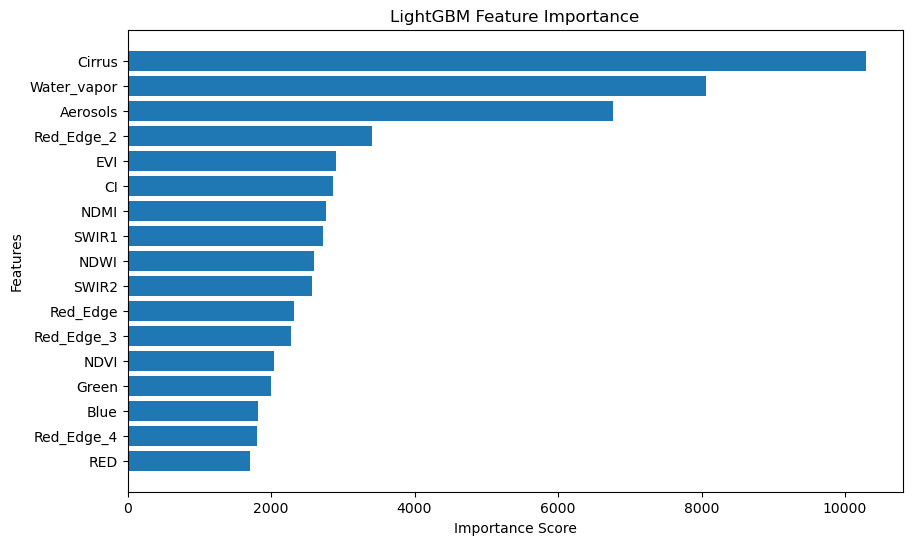

In [169]:
best_model = grid_search.best_estimator_.named_steps["lgbmclassifier"]

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"]
         )
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()  # Corrected this line
plt.show()

In [170]:
feature_importance

,Feature,Importance
11,Cirrus,10286
10,Water_vapor,8058
6,Aerosols,6764
7,Red_Edge_2,3409
15,EVI,2901
16,CI,2857
13,NDMI,2772
3,SWIR1,2722
14,NDWI,2599
4,SWIR2,2577


In [171]:
from sklearn.ensemble import RandomForestClassifier

# isntantiatie the class
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# fit model to train val datasets
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [172]:
# Training data f1_score
y_pred = rf_model.predict(X_train)
score_train = f1_score(y_train, y_pred, average='weighted')
print(f"F1 Score for the Baseline training data: {round(score_train,4)}")

# Validation f1_score
y_pred_1 = rf_model.predict(X_val)
sore_val = f1_score(y_val,y_pred_1, average='weighted')
print(f"F1 Score for the Baseline validation data: {round(score_train,4)}")

F1 Score for the Baseline training data: 1.0
F1 Score for the Baseline validation data: 1.0


In [173]:
len(X_train.index.values)

20947

In [174]:
 0.9917393059253834

0.9917393059253834

## Test Datasets

In [175]:
# Load files and clean dataset
test = os.path.join(DATA_DIR / 'Test.csv')

# preprocess and extract features
test_df = load_and_clean_dataset(test)
test_df = extract_time(test_df)

# create target column
test_df['Target'] = 0

test_df = fill_missing_value(test_df)
test_df = feature_eng_evi(test_df)

test_df = aggregate_dataset(test_df)

test_df.head()


,ID,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,EVI,CI,Target
0,1D_0005,0.269574,0.289363,0.264415,0.361094,0.251045,0.158263,0.268254,0.311518,0.342355,0.399212,0.426128,0.088024,0.010221,0.278020,0.202949,-0.222745,0.311995,0.050226,0.0
1,1D_000A,0.271481,0.290375,0.265776,0.398713,0.258726,0.159674,0.271693,0.310459,0.361773,0.427363,0.458777,0.090193,0.009966,0.326615,0.240510,-0.275098,0.403090,0.061182,0.0
2,1D_000D,0.271598,0.292014,0.266304,0.372353,0.253403,0.158648,0.269136,0.312981,0.346291,0.405110,0.433285,0.089354,0.010001,0.292334,0.212733,-0.238293,0.340353,0.046739,0.0
3,1D_000E,0.276286,0.293892,0.269940,0.390459,0.254516,0.157710,0.273957,0.311448,0.354669,0.413292,0.441320,0.089541,0.010018,0.303352,0.238966,-0.249908,0.369007,0.050191,0.0
4,1D_0015,0.277222,0.294147,0.271470,0.407985,0.265594,0.165763,0.277988,0.312776,0.371296,0.437706,0.469535,0.089882,0.009906,0.323498,0.238744,-0.271707,0.403659,0.064108,0.0


In [176]:
test_df.columns

Index(['ID', 'Green', 'Blue', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'Red_Edge',
       'Aerosols', 'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor',
       'Cirrus', 'NDVI', 'NDMI', 'NDWI', 'EVI', 'CI', 'Target'],
      dtype='object')

In [177]:
# test if there is no duplicates 'ID'
assert test_df.groupby("ID")["Target"].nunique().max() == 1
assert test_df.groupby("ID")["Target"].nunique().min() == 1

In [178]:
# Add high-cardinality / redundant column
df_test = test_df.drop(['ID'],axis =1)
df_test.head()

,Green,Blue,RED,NIR,SWIR1,SWIR2,Red_Edge,Aerosols,Red_Edge_2,Red_Edge_3,Red_Edge_4,Water_vapor,Cirrus,NDVI,NDMI,NDWI,EVI,CI,Target
0,0.269574,0.289363,0.264415,0.361094,0.251045,0.158263,0.268254,0.311518,0.342355,0.399212,0.426128,0.088024,0.010221,0.278020,0.202949,-0.222745,0.311995,0.050226,0.0
1,0.271481,0.290375,0.265776,0.398713,0.258726,0.159674,0.271693,0.310459,0.361773,0.427363,0.458777,0.090193,0.009966,0.326615,0.240510,-0.275098,0.403090,0.061182,0.0
2,0.271598,0.292014,0.266304,0.372353,0.253403,0.158648,0.269136,0.312981,0.346291,0.405110,0.433285,0.089354,0.010001,0.292334,0.212733,-0.238293,0.340353,0.046739,0.0
3,0.276286,0.293892,0.269940,0.390459,0.254516,0.157710,0.273957,0.311448,0.354669,0.413292,0.441320,0.089541,0.010018,0.303352,0.238966,-0.249908,0.369007,0.050191,0.0
4,0.277222,0.294147,0.271470,0.407985,0.265594,0.165763,0.277988,0.312776,0.371296,0.437706,0.469535,0.089882,0.009906,0.323498,0.238744,-0.271707,0.403659,0.064108,0.0


In [179]:
X_columns = X_train.columns
df_test = df_test[X_columns]

In [180]:
df_test.columns

Index(['Green', 'Blue', 'RED', 'SWIR1', 'SWIR2', 'Red_Edge', 'Aerosols',
       'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor', 'Cirrus',
       'NDVI', 'NDMI', 'NDWI', 'EVI', 'CI'],
      dtype='object')

In [181]:
# predict with the test dataset
# prediction = lightgbm_model.predict(df_test)
# prediction = rf_model.predict(df_test)
prediction = grid_search.predict(df_test)
prediction

array([0., 0., 0., ..., 1., 0., 1.])

### Model Explainability

In [182]:
grid_search.feature_names_in_

array(['Green', 'Blue', 'RED', 'SWIR1', 'SWIR2', 'Red_Edge', 'Aerosols',
       'Red_Edge_2', 'Red_Edge_3', 'Red_Edge_4', 'Water_vapor', 'Cirrus',
       'NDVI', 'NDMI', 'NDWI', 'EVI', 'CI'], dtype=object)

In [183]:
grid_search.best_estimator_

Pipeline(steps=[('smote',
                 SMOTETomek(random_state=42, sampling_strategy='minority')),
                ('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', n_estimators=1100,
                                num_class=3, num_leaves=50,
                                objective='multiclass', random_state=42,
                                reg_alpha=0, reg_lambda=0))])

## Making your submission

In [184]:
# Preview sample submission
sample_submission = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')
sample_submission.head()

,ID,Target
0,1D_0005,0
1,1D_000A,0
2,1D_000D,0
3,1D_000E,0
4,1D_0015,0


In [185]:
# Prepare submission data
test_df['Target'] = prediction
final_sub =test_df[['ID','Target']]

# Prepares sub file
final_sub['Target'] = final_sub['Target'].astype(int)
final_sub.head()

,ID,Target
0,1D_0005,0
1,1D_000A,0
2,1D_000D,0
3,1D_000E,0
4,1D_0015,0


In [186]:
# Create submission to be uploaded to Zindi for scoring
final_sub.to_csv('Submission.csv', index = False)